In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
ss=1; make_time_resolved=False
_, _, main_labels, roi_names = data_utils.load_main_task_data(ss, make_time_resolved)

In [3]:
xlabs = np.array(main_labels['ptx'])[main_labels['is_main_grid']==True]
ylabs = np.array(main_labels['pty'])[main_labels['is_main_grid']==True]
unx, uny = np.unique(xlabs), np.unique(ylabs)
pt_labs = np.array([xlabs, ylabs]).T
grid_pts, grid_labs, counts = np.unique(pt_labs, axis=0, return_inverse=True, return_counts=True)
grid_pt_strs = np.array(['(%.1f, %.1f)'%(grid_pts[ii,0], grid_pts[ii,1]) for ii in range(len(grid_pts))])
grid_pt_strs

array(['(0.1, 0.1)', '(0.1, 1.7)', '(0.1, 3.3)', '(0.1, 4.9)',
       '(1.7, 0.1)', '(1.7, 1.7)', '(1.7, 3.3)', '(1.7, 4.9)',
       '(3.3, 0.1)', '(3.3, 1.7)', '(3.3, 3.3)', '(3.3, 4.9)',
       '(4.9, 0.1)', '(4.9, 1.7)', '(4.9, 3.3)', '(4.9, 4.9)'],
      dtype='<U10')

In [22]:
grid_pts

array([[0.1, 0.1],
       [0.1, 1.7],
       [0.1, 3.3],
       [0.1, 4.9],
       [1.7, 0.1],
       [1.7, 1.7],
       [1.7, 3.3],
       [1.7, 4.9],
       [3.3, 0.1],
       [3.3, 1.7],
       [3.3, 3.3],
       [3.3, 4.9],
       [4.9, 0.1],
       [4.9, 1.7],
       [4.9, 3.3],
       [4.9, 4.9]])

In [4]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

roi_names = ['V1', 'V2', 'V3', 'V3AB', 'hV4', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'LO1', 'LO2']
n_rois = 11

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_allmaintask.npy')
dec = np.load(save_filename, allow_pickle=True).item()
dec.keys()

dict_keys(['acc_overall', 'dprime_overall', 'acc_each_point', 'dprime_each_point', 'num_preds', 'acc_each_cval', 'best_cval'])

In [6]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()

dict_keys(['acc_bytask', 'dprime_bytask', 'acc_each_point_bytask', 'dprime_each_point_bytask', 'num_preds_bytask', 'acc_each_cval', 'best_cval', 'grid_pts', 'roi_names'])

#### Accuracy versus c (regularization)

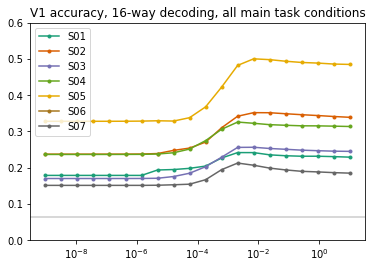

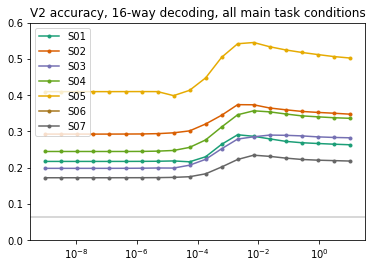

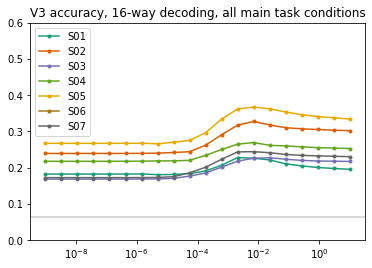

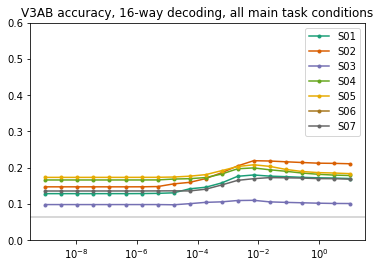

In [10]:
c_values = np.logspace(-9, 1, 20)
# for rr in range(n_rois):
for rr in [0,1,2,3]:

    plt.figure()

    for si in range(n_subjects):

        vals = np.mean(dec['acc_each_cval'][si, rr, :, :], axis=0)

        plt.plot(c_values, vals, '.-', color=subcolors[si,:], )

    plt.gca().set_xscale('log')
    plt.legend(['S%02d'%ss for ss in subjects])

    plt.ylim([0, 0.6])
    plt.axhline(1/16, color=[0.8, 0.8, 0.8])
    plt.title('%s accuracy, 16-way decoding, all main task conditions'%roi_names[rr])

#### best overall acc

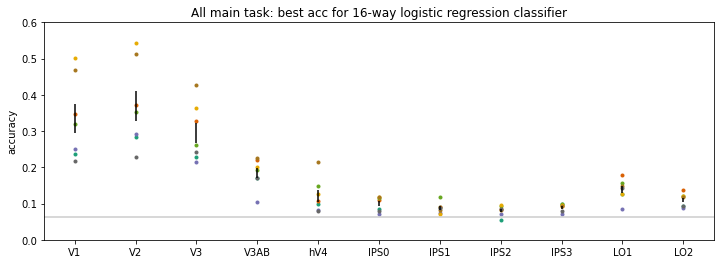

In [11]:
vals = dec['acc_overall']
n_subj = vals.shape[0]
n_rois = vals.shape[1]
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj)
plt.figure(figsize=(12,4))
plt.errorbar(np.arange(n_rois), meanvals, semvals, linestyle='none',color='k', zorder=10)
for si in range(n_subj):
    plt.plot(np.arange(n_rois), vals[si,:], '.', color=subcolors[si,:])
plt.xticks(np.arange(n_rois), roi_names);
plt.ylim([0, 0.6])
plt.axhline(1/16, color=[0.8, 0.8, 0.8])
plt.ylabel('accuracy')
plt.title('All main task: best acc for 16-way logistic regression classifier');

#### within-task decoding acc 
a bit worse

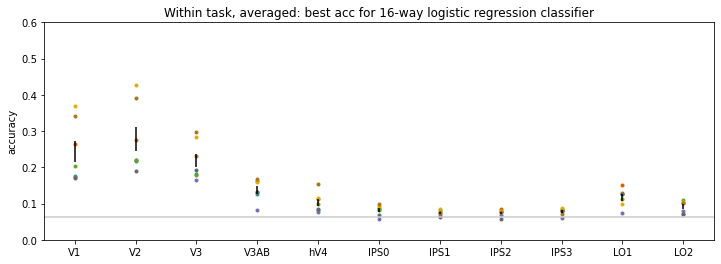

In [12]:
vals = np.mean(dec_withintask['acc_bytask'], axis=2)

n_subj = vals.shape[0]
n_rois = vals.shape[1]
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj)
plt.figure(figsize=(12,4))
plt.errorbar(np.arange(n_rois), meanvals, semvals, linestyle='none',color='k', zorder=10)
for si in range(n_subj):
    plt.plot(np.arange(n_rois), vals[si,:], '.', color=subcolors[si,:])
plt.xticks(np.arange(n_rois), roi_names);
plt.ylim([0, 0.6])
plt.axhline(1/16, color=[0.8, 0.8, 0.8])
plt.ylabel('accuracy')
plt.title('Within task, averaged: best acc for 16-way logistic regression classifier');

#### Accuracy broken down by task

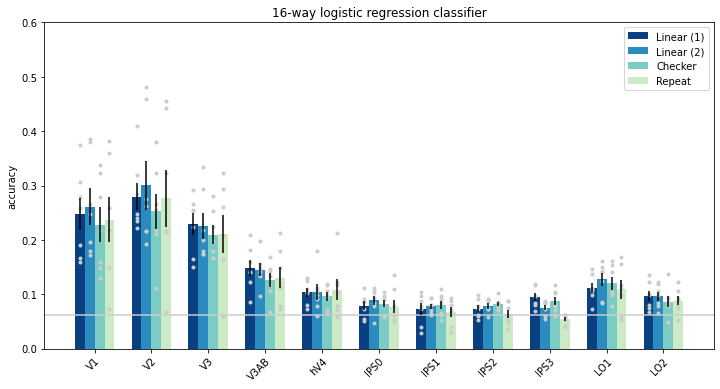

In [13]:
vals = dec_withintask['acc_bytask']

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj-1)

plot_utils.plot_multi_bars(mean_data = meanvals, \
                           err_data = semvals, \
                           point_data = vals, \
                           add_ss_lines=False,
                           colors = task_colors, \
                           space = 0.15, \
                           title = '16-way logistic regression classifier', \
                           ylim = [0, 0.6], \
                           horizontal_line_pos = 1/16,
                           xticklabels = roi_names, \
                           ylabel = 'accuracy', \
                           legend_overlaid=True, \
                           legend_separate=False, \
                           legend_labels = np.array(task_names));

#### Make confusion matrix

Text(0.5, 1.0, 'V2, all main task conds')

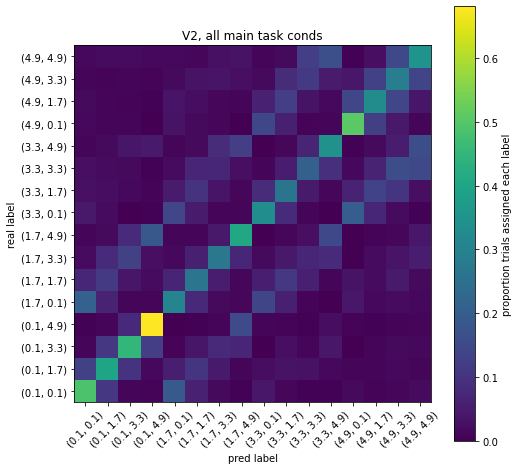

In [7]:
ri = 1;
# sum over subjects
n = np.sum(dec['num_preds'][:,ri,:,:], axis=0)
# sum over all trials with same "real label"
s = np.tile(np.sum(n, axis=1, keepdims=True), [1,n.shape[1]])
prop_conf =  n/s

plt.figure(figsize=(8,8))
plt.pcolormesh(prop_conf)
plt.colorbar(label='proportion trials assigned each label')
plt.ylabel('real label')
plt.xlabel('pred label')
plt.xticks(np.arange(0.5, 16.5, 1.0), grid_pt_strs, rotation=45);
plt.yticks(np.arange(0.5, 16.5, 1.0), grid_pt_strs);
plt.axis('square')
plt.title('%s, all main task conds'%roi_names[ri])

#### Make idealized confusion matrices for each task

In [33]:
n_grid_pts = 16;
ideal_conf_matrices = np.zeros((n_grid_pts, n_grid_pts, n_tasks))
for gg1 in range(n_grid_pts):
    for gg2 in range(n_grid_pts):
        
        pt1 = grid_pts[gg1,:]
        pt2 = grid_pts[gg2,:]
        
        xcat1 = pt1[0]>center
        xcat2 = pt2[0]>center
        
        ycat1 = pt1[1]>center
        ycat2 = pt2[1]>center
        
        if xcat1==xcat2:
            ideal_conf_matrices[gg1,gg2,0] = 1
            
        if ycat1==ycat2:
            ideal_conf_matrices[gg1,gg2,1] = 1
            
        checker1 = np.sum(pt1>center)==1
        checker2 = np.sum(pt2>center)==1
        
        if checker1==checker2:
            ideal_conf_matrices[gg1,gg2,2] = 1
            
        if np.all(pt1==pt2):
            ideal_conf_matrices[gg1,gg2,3] = 1
            

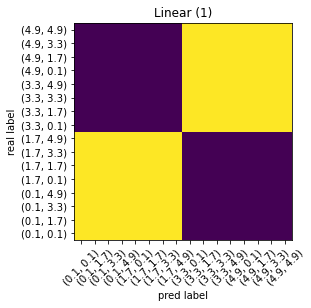

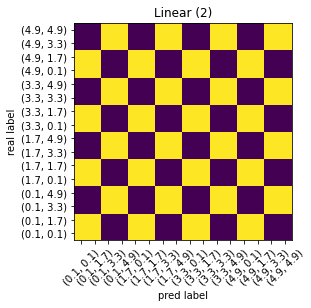

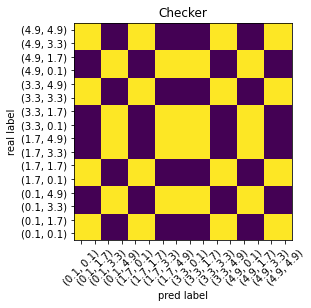

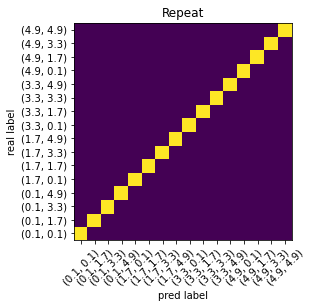

In [34]:
for ti in range(n_tasks):
    
    plt.figure()
    plt.pcolormesh(ideal_conf_matrices[:,:,ti])
    
    plt.ylabel('real label')
    plt.xlabel('pred label')
    plt.xticks(np.arange(0.5, 16.5, 1.0), grid_pt_strs, rotation=45);
    plt.yticks(np.arange(0.5, 16.5, 1.0), grid_pt_strs);
    plt.axis('square')
    plt.title('%s'%task_names[ti])

#### Correlate the confusion matrices with the templates

In [58]:
sim_each = np.zeros((n_subjects, n_rois, n_tasks, n_tasks))

for si in range(n_subjects):

    for ri in range(n_rois):
        for ti in range(n_tasks):

            n = dec_withintask['num_preds_bytask'][si,ri,:,:,ti]
            
            # n = np.sum(dec_withintask['num_preds_bytask'][:,ri,:,:,ti], axis=0)
            # sum over all trials with same "real label"
            s = np.tile(np.sum(n, axis=1, keepdims=True), [1,n.shape[1]])
            prop_conf =  n/s

            for ti_compare in range(n_tasks):

                ideal = ideal_conf_matrices[:,:,ti_compare]

                # similarity of ideal with actual
                sim = np.corrcoef(prop_conf.ravel(), ideal.ravel())[0,1]

                sim_each[si, ri, ti, ti_compare] = sim

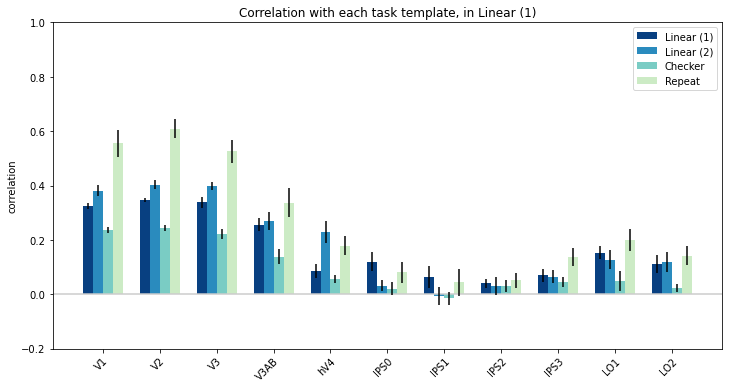

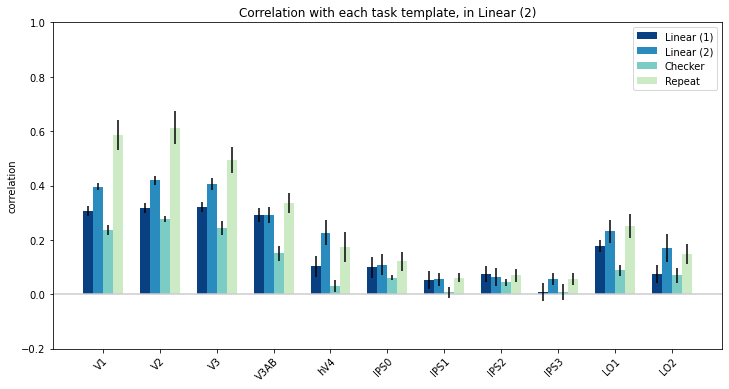

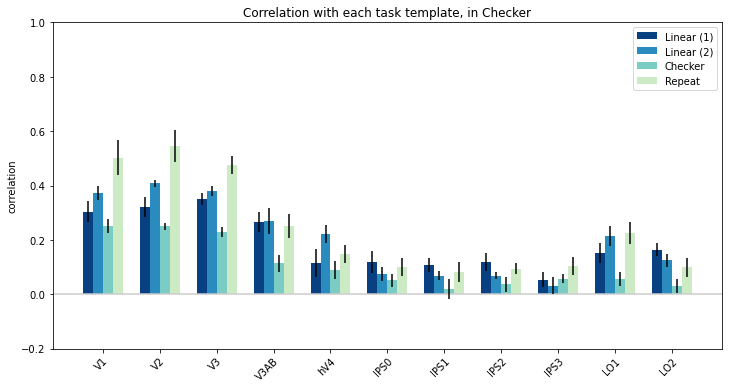

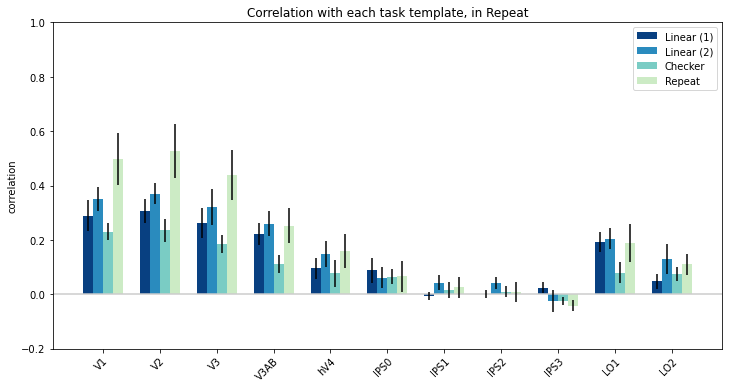

In [59]:
for ti in range(n_tasks):

    vals = sim_each[:,:,ti,:]
    
    
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

    plot_utils.plot_multi_bars(mean_data = meanvals, \
                               err_data = semvals, \
                               # point_data = vals, \
                               # add_ss_lines=False,
                               colors = task_colors, \
                               space = 0.15, \
                               title = 'Correlation with each task template, in %s'%task_names[ti], \
                               ylim = [-0.2, 1.0], 
                               # horizontal_line_pos = 1/16,
                               xticklabels = roi_names, \
                               ylabel = 'correlation', \
                               legend_overlaid=True, \
                               legend_separate=False, \
                               legend_labels = np.array(task_names));

#### within task

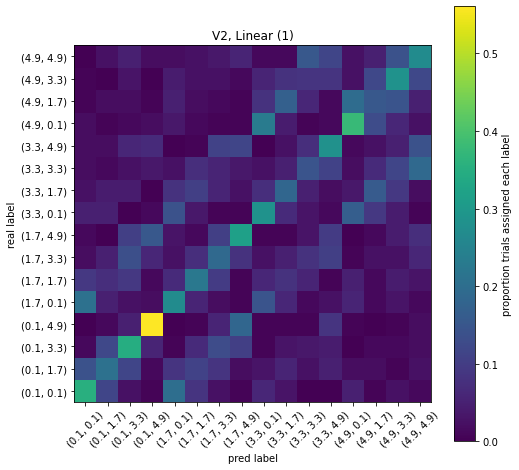

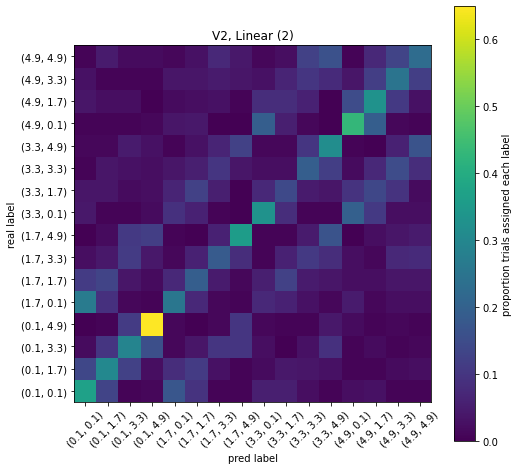

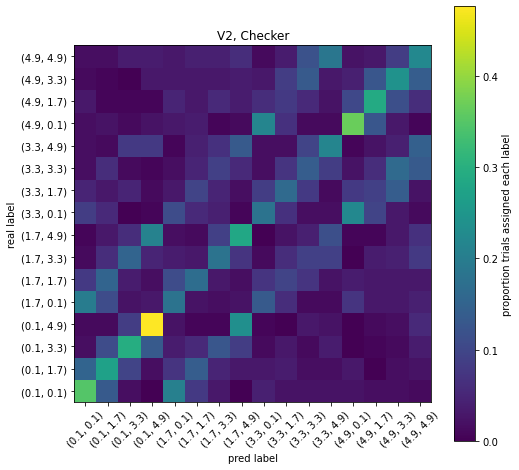

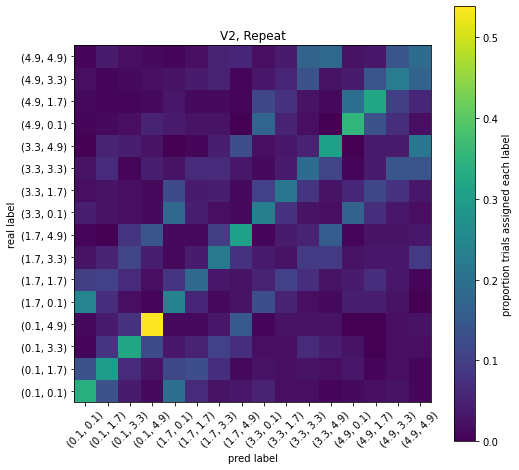

In [35]:
ri = 1;
for ti in range(4):

    # sum over subjects
    n = np.sum(dec_withintask['num_preds_bytask'][:,ri,:,:,ti], axis=0)
    # sum over all trials with same "real label"
    s = np.tile(np.sum(n, axis=1, keepdims=True), [1,n.shape[1]])
    prop_conf =  n/s

    plt.figure(figsize=(8,8))
    plt.pcolormesh(prop_conf)
    plt.colorbar(label='proportion trials assigned each label')
    plt.ylabel('real label')
    plt.xlabel('pred label')
    plt.xticks(np.arange(0.5, 16.5, 1.0), grid_pt_strs, rotation=45);
    plt.yticks(np.arange(0.5, 16.5, 1.0), grid_pt_strs);
    plt.axis('square')
    plt.title('%s, %s'%(roi_names[ri], task_names[ti]))

#### try subtracting tasks?

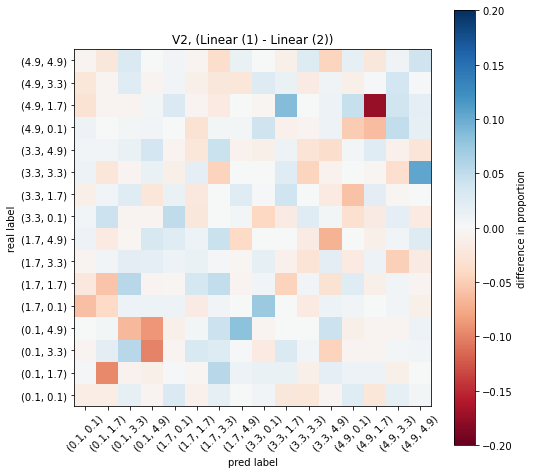

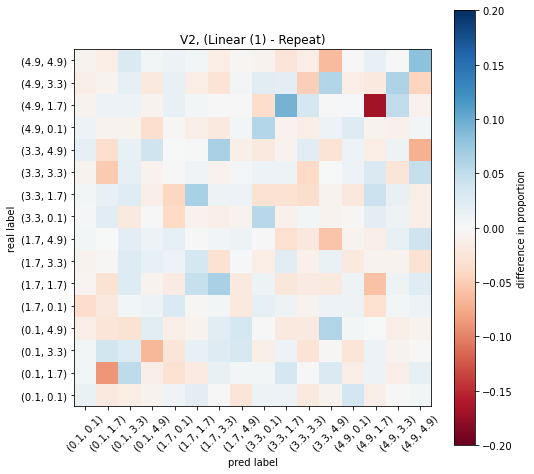

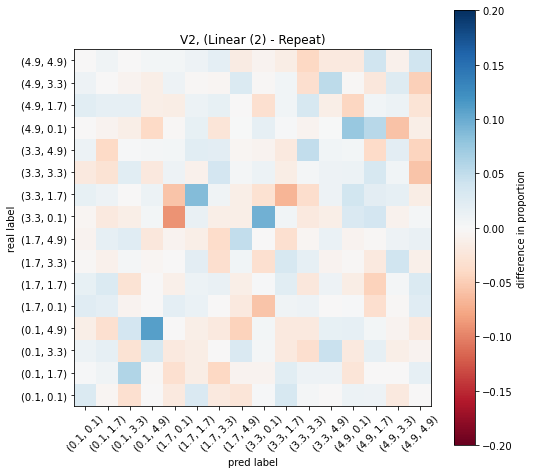

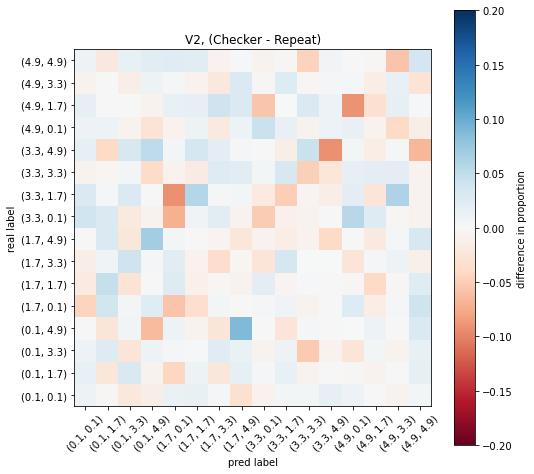

In [16]:
ri = 1;
for ti_diff in [[0,1], [0,3], [1,3], [2,3]]:

    # sum over subjects
    n = np.sum(dec_withintask['num_preds_bytask'][:,ri,:,:,ti_diff[0]], axis=0)
    # sum over all trials with same "real label"
    s = np.tile(np.sum(n, axis=1, keepdims=True), [1,n.shape[1]])
    prop_conf1 =  n/s

    # sum over subjects
    n = np.sum(dec_withintask['num_preds_bytask'][:,ri,:,:,ti_diff[1]], axis=0)
    # sum over all trials with same "real label"
    s = np.tile(np.sum(n, axis=1, keepdims=True), [1,n.shape[1]])
    prop_conf2 =  n/s

    prop_conf = prop_conf1 - prop_conf2
    
    plt.figure(figsize=(8,8))
    plt.pcolormesh(prop_conf, vmin=-0.2, vmax=0.2, cmap = 'RdBu')
    plt.colorbar(label='difference in proportion')
    plt.ylabel('real label')
    plt.xlabel('pred label')
    plt.xticks(np.arange(0.5, 16.5, 1.0), grid_pt_strs, rotation=45);
    plt.yticks(np.arange(0.5, 16.5, 1.0), grid_pt_strs);
    plt.axis('square')
    plt.title('%s, (%s - %s)'%(roi_names[ri], task_names[ti_diff[0]], task_names[ti_diff[1]]))

#### overall dprime for each grid point

Text(0.5, 1.0, 'V2')

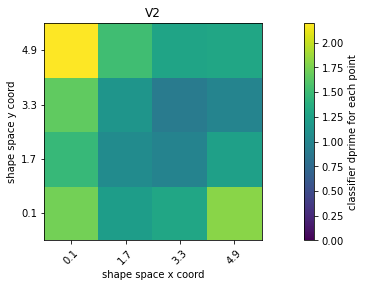

In [18]:
ri = 1

meanvals = np.mean(dec['dprime_each_point'][:,ri,:], axis=0)
meanvals = meanvals.reshape([4,4] , order='C')
plt.figure()
plt.pcolormesh(meanvals.T, vmin=0, vmax=2.2)
plt.colorbar(label='classifier dprime for each point')
plt.ylabel('shape space y coord')
plt.xlabel('shape space x coord')
plt.xticks(np.arange(0.5, 4.5, 1.0), unx, rotation=45);
plt.yticks(np.arange(0.5, 4.5, 1.0), uny);
plt.axis('square')
plt.title(roi_names[ri])

# meanvals = np.mean(dec['dprime_each_point'][:,ri,:], axis=0)
# plt.figure(figsize=(12,3))
# plt.plot(np.arange(16), meanvals,'.')
# plt.xticks(np.arange(16), grid_pt_strs, rotation=45)
# plt.title(roi_names[ri])

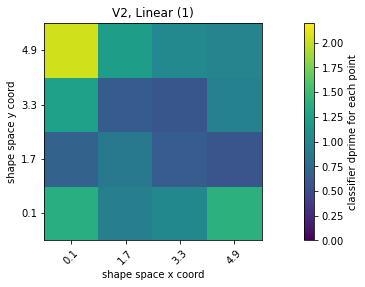

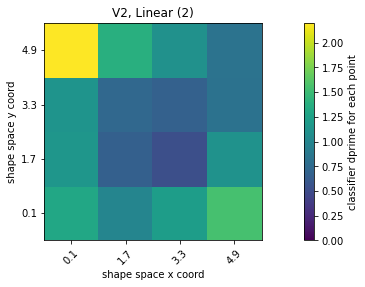

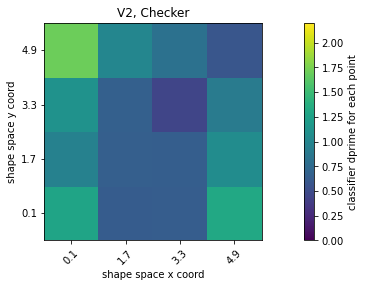

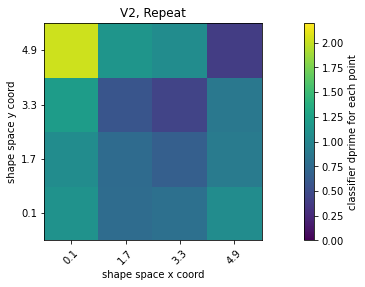

In [19]:
ri = 1

for ti in range(4):

    meanvals = np.mean(dec_withintask['dprime_each_point_bytask'][:,ri,:,ti], axis=0)
    meanvals = meanvals.reshape([4,4] , order='C')
    plt.figure()
    plt.pcolormesh(meanvals.T, vmin=0, vmax=2.2)
    plt.colorbar(label='classifier dprime for each point')
    plt.ylabel('shape space y coord')
    plt.xlabel('shape space x coord')
    plt.xticks(np.arange(0.5, 4.5, 1.0), unx, rotation=45);
    plt.yticks(np.arange(0.5, 4.5, 1.0), uny);
    plt.axis('square')
    plt.title('%s, %s'%(roi_names[ri], task_names[ti]))

# meanvals = np.mean(dec['dprime_each_point'][:,ri,:], axis=0)
# plt.figure(figsize=(12,3))
# plt.plot(np.arange(16), meanvals,'.')
# plt.xticks(np.arange(16), grid_pt_strs, rotation=45)
# plt.title(roi_names[ri])

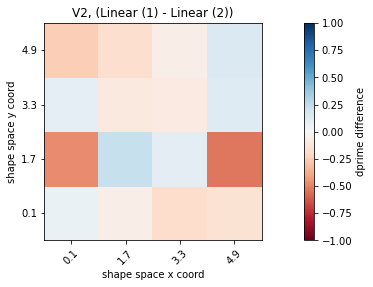

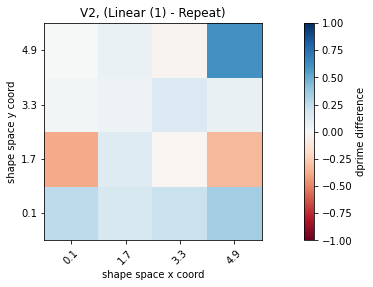

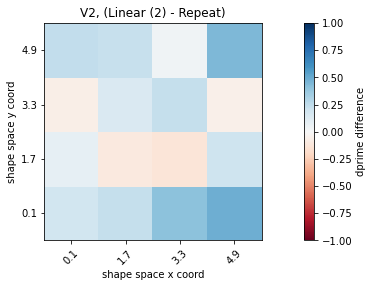

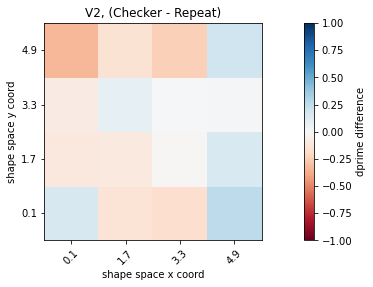

In [20]:
ri = 1

for ti_diff in [[0,1], [0,3], [1,3], [2,3]]:

    meanvals1 = np.mean(dec_withintask['dprime_each_point_bytask'][:,ri,:,ti_diff[0]], axis=0)
    meanvals2 = np.mean(dec_withintask['dprime_each_point_bytask'][:,ri,:,ti_diff[1]], axis=0)
    meanvals = meanvals1 - meanvals2
    
    meanvals = meanvals.reshape([4,4] , order='C')
    plt.figure()
    plt.pcolormesh(meanvals.T, vmin=-1, vmax=1, cmap = 'RdBu')
    plt.colorbar(label='dprime difference')
    plt.ylabel('shape space y coord')
    plt.xlabel('shape space x coord')
    plt.xticks(np.arange(0.5, 4.5, 1.0), unx, rotation=45);
    plt.yticks(np.arange(0.5, 4.5, 1.0), uny);
    plt.axis('square')
    plt.title('%s, (%s - %s)'%(roi_names[ri], task_names[ti_diff[0]], task_names[ti_diff[1]]))

# meanvals = np.mean(dec['dprime_each_point'][:,ri,:], axis=0)
# plt.figure(figsize=(12,3))
# plt.plot(np.arange(16), meanvals,'.')
# plt.xticks(np.arange(16), grid_pt_strs, rotation=45)
# plt.title(roi_names[ri])

#### from the 16-way classifier predictions, compute binary d'

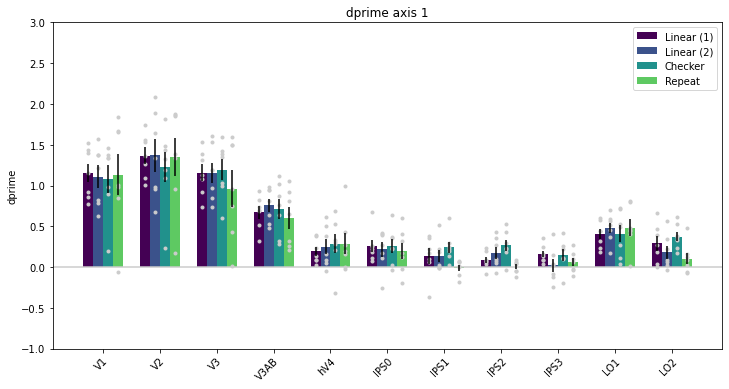

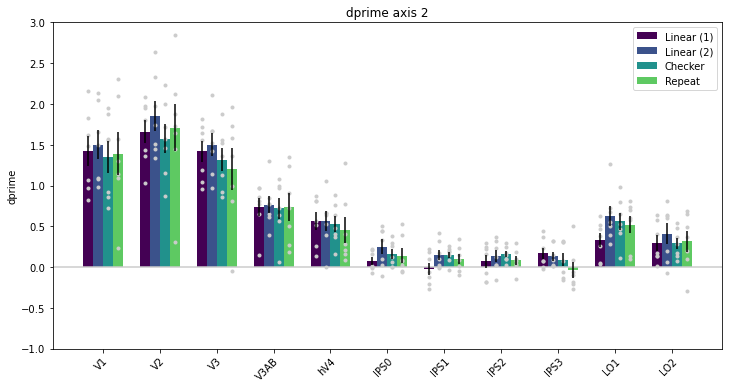

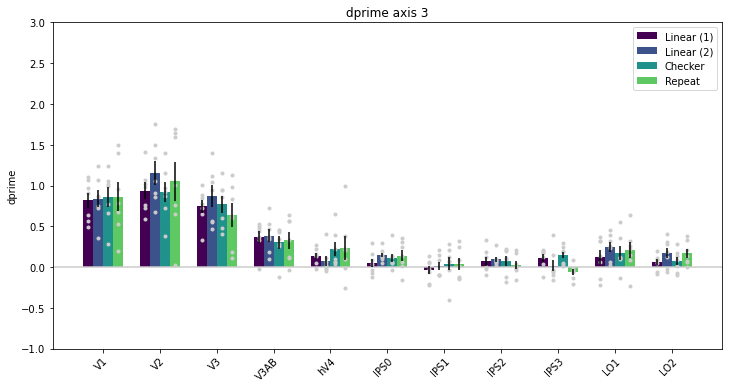

In [251]:
dprime_each_axis = np.zeros((n_subjects, n_rois, n_tasks, 3))

center = 2.5

for si in range(n_subjects):
    for ri in range(n_rois):
        for ti in range(n_tasks):
            
            # [16 x 16], [real label, pred label]
            vals = dec_withintask['num_preds_bytask'][si,ri,:,:,ti]
            
            for axis in range(3):

                if axis<2:
                    # binarize the 16 points along axis of interest here
                    binary_labs = (grid_pts[:,axis]>center).astype(int)
                else:
                    binary_labs = ((grid_pts[:,0]>center)==(grid_pts[:,1]>center)).astype(int)
                    
                # find how often classifier confused across the boundary.
                counts_each = np.zeros((2,2)) # [real label, pred label]
                for ii in [0,1]:
                    for jj in [0,1]:
                        counts_each[ii,jj] = np.sum(vals[binary_labs==ii,:,][:,binary_labs==jj])

                # compute discriminability across boundary (d')
                hr = counts_each[0,0] / np.sum(counts_each[0,:])
                hrz = scipy.stats.norm.ppf(hr,0,1)
                fp = counts_each[1,0] / np.sum(counts_each[1,:])
                fpz = scipy.stats.norm.ppf(fp,0,1)
                dprime = hrz - fpz

                dprime_each_axis[si, ri, ti, axis] = dprime

for ai, axis in enumerate([1,2,3]):

    vals = dprime_each_axis[:,:,:,ai]

    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subj-1)

    plot_utils.plot_multi_bars(mean_data = meanvals, \
                               err_data = semvals, \
                               point_data = vals, \
                               add_ss_lines=False, \
                               colors = task_colors, \
                               space = 0.15, \
                               title = 'dprime axis %d'%axis, \
                               ylim = [-1, 3], \
                               horizontal_line_pos = 0,
                               xticklabels = roi_names, \
                               ylabel = 'dprime', \
                               legend_overlaid=True, \
                               legend_separate=False, \
                               legend_labels = np.array(task_names));

In [234]:
cross_bound1_pairs = [[[1.7, ii], [3.3, ii]] for ii in [0.1, 1.7, 3.3, 4.9]]
cross_bound2_pairs = [[[ii, 1.7], [ii, 3.3]] for ii in [0.1, 1.7, 3.3, 4.9]]
cross_bound1_pairs, cross_bound2_pairs

([[[1.7, 0.1], [3.3, 0.1]],
  [[1.7, 1.7], [3.3, 1.7]],
  [[1.7, 3.3], [3.3, 3.3]],
  [[1.7, 4.9], [3.3, 4.9]]],
 [[[0.1, 1.7], [0.1, 3.3]],
  [[1.7, 1.7], [1.7, 3.3]],
  [[3.3, 1.7], [3.3, 3.3]],
  [[4.9, 1.7], [4.9, 3.3]]])

In [235]:
pair = cross_bound1_pairs[0]
ind1 = np.where(np.all(grid_pts==np.array(pair[0]), axis=1))[0][0]
ind2 = np.where(np.all(grid_pts==np.array(pair[1]), axis=1))[0][0]
ind1, ind2

(4, 8)

In [236]:
for pair in cross_bound1_pairs:
    ind1 = np.where(np.all(grid_pts==np.array(pair[0]), axis=1))[0][0]
    ind2 = np.where(np.all(grid_pts==np.array(pair[1]), axis=1))[0][0]

In [163]:
dec_withintask['acc_bytask'].shape

(7, 11, 4)